# Analytics - Product Quality

#### Date: 2022/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2022/01
##### Professor: Hilmer Neri

##### Members:

- Guilherme Leal
- João Pedro Soares
- Lucas Alexandre
- Matheus Estanislau
- Moacir Mascarenha
- Igor Silva de Paiva
- João Pedro Alves Machado
- Mário Vinícius
- Lucas Heler Lopes
- Pedro Siqueira
- Wildemberg Sales da Silva Junior

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os
import re

# Deal with visualization
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
fig = plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
language = [['fga-eps-mds-2022-1-Alectrion-EquipamentApi', 'ts']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('analytics-raw-data2/*.json') # add your path here

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2022-1-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)
    
    df['repository'] = aux_df[2]
    
    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_3723/108625875.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3723/108625875.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3723/108625875.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3723/108625875.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3723/108625875.py:22: FutureWarning: The frame.append method is deprecated and will b

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
0,duplicated_lines_density,1.9,False,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
1,functions,45,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
2,test_execution_time,63,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
3,test_failures,0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
4,test_errors,0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
5,security_rating,1.0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
6,tests,42,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
7,files,19,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
8,complexity,121,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0
9,ncloc,870,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.11.0


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [10]:
def get_files_df(df):
    
    files = df[df['qualifier'] == 'FIL'] 
    
    files = files.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])
    
    return files

In [11]:
def get_dir_df(df):
    
    dirs = df[df["qualifier"] == "DIR"]     
    
    dirs = dirs.dropna(subset=['tests', 'test_errors','test_failures'])

    newdf = pd.to_numeric(dirs["tests"])
    
    max_value_index = newdf.idxmax()            
    
    return dirs.loc[max_value_index]

In [12]:
def get_uts_df(df):
    
    dirs = df[df['qualifier'] == 'UTS']   
    
    dirs = dirs.dropna(subset=['test_execution_time'])
    
    return dirs

In [13]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        
        ncloc_value = 0;
        
        for valores in component['measures']:

            if valores['metric'] == 'ncloc':
                ncloc_value = float(valores['value'])
                break
    
        if (component['qualifier'] == 'FIL') & (ncloc_value > 0) or (component['qualifier'] == 'DIR') or (component['qualifier'] == 'UTS'):                       
            file_json.append(component)

    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    df2 = pd.DataFrame(columns = df_columns)
    df3 = pd.DataFrame(columns = df_columns)
    
    
    for file in json:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        df.at[file['path'], measure['metric']] = measure['value']

                    df['qualifier'] = file['qualifier'] 

                elif file['qualifier'] == 'UTS':  
                    for measure in file['measures']:
                        df3.at[file['path'], measure['metric']] = measure['value']

                    df3['qualifier'] = file['qualifier'] 
                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        df2.at[file['path'], measure['metric']] = measure['value']
                    df2['qualifier'] = file['qualifier'] 
        except:
            pass

    df.reset_index(inplace = True)
    df2.reset_index(inplace = True)
    df3.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df2 = df2.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    df3 = df3.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    dfFinal = pd.concat([df,df2,df3], axis=0)

    return dfFinal

def create_file_df(json_list):
    
    df = pd.DataFrame()
    dfDir = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
                        
        file_name = os.path.basename(i)

        file_repository = re.split(r'-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json', file_name)[0]

        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = file_language)
        
        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['version'])
    
    return df

In [14]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

/tmp/ipykernel_3723/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3723/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3723/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3723/3038128456.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3723/3038128456.py:80: FutureWarning: The frame.append method is deprecated and w

array(['fga-eps-mds-2022-1-Alectrion-EquipamentApi'], dtype=object)

#### Removing NaN

In [15]:
#file_component_df = file_component_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

        ### Create dataframe per repository

In [16]:
# Example. You must replace repo1, repo1,..., for your repository's names

repo3_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-EquipamentApi']
...

Ellipsis

In [17]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [18]:
def m1(df):

    files_df = get_files_df(df)
    density_non_complex_files = 0
    try:
        density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)
    except ZeroDivisionError:
        pass
    
    return density_non_complex_files

##### COMMENTS

In [19]:
def m2(df):

    files_df = get_files_df(df)
    density_comment_files = 0
    try:
        density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)
    except ZeroDivisionError:
        pass
    
    return density_comment_files

##### DUPLICATIONS

In [20]:
def m3(df):
    
    files_df = get_files_df(df)
    duplication = 0
    
    try:
        duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)
    except ZeroDivisionError:
        pass
        
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [21]:
def m4(df):
    
    cont = 0
    dir_df = get_dir_df(df)
    passed_tests = 0
    
    try:
        passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
                   float(dir_df['tests'])
    except ValueError:
        cont+=1
        
    except ZeroDivisionError:
        pass
    
    return passed_tests

##### Fast test builds

In [22]:
def m5(df):

    dir_df = get_uts_df(df)
    density_fast_test_builds = 0
    
    try:
        density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    except ZeroDivisionError:
        pass
    
    return density_fast_test_builds

##### Test coverage

In [23]:
def m6(df):
    
    files_df = get_files_df(df)
    density_test_coverage = 0
    
    try:
        density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)
    except ZeroDivisionError:
        pass
    
    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [24]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    for version in version_vec:

        version_df = df[df['version'] == version]
        
        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
      
    return metrics_df

In [25]:
repo3 = create_metrics_df(repo3_df.fillna(0))
...

### Data visualization

- You must do this for each of your repositories

In [26]:
#Alectrion EquipamentAPI
repo3

,m1,m2,m3,m4,m5,m6,repository,version,ncloc
0,0.526316,0.0,1.000000,1.0,1.0,0.210526,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.11.0,3391
1,0.500000,0.0,1.000000,0.0,0.0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.2.0,48
2,0.416667,0.0,1.000000,0.0,0.0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.3.0,1113
3,0.833333,0.0,0.958333,0.0,0.0,0.083333,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.4.0,5347
4,0.727273,0.0,0.909091,0.0,0.0,0.045455,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.6.0,2905
5,0.678161,0.0,0.988506,1.0,1.0,0.183908,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.8.0,8531


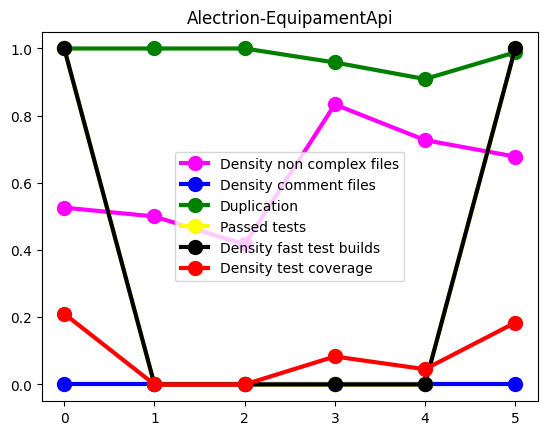

In [27]:
plt.title('Alectrion-EquipamentApi')
plt.plot(repo3['m1'], linewidth=3, marker='o', markersize=10, color="magenta", label="Density non complex files")
plt.plot(repo3['m2'], linewidth=3, marker='o', markersize=10, color="blue", label="Density comment files")
plt.plot(repo3['m3'], linewidth=3, marker='o', markersize=10, color="green", label="Duplication")
plt.plot(repo3['m4'], linewidth=3, marker='o', markersize=10, color="yellow", label="Passed tests")
plt.plot(repo3['m5'], linewidth=3, marker='o', markersize=10, color="black", label="Density fast test builds")
plt.plot(repo3['m6'], linewidth=3, marker='o', markersize=10, color="red", label="Density test coverage")
plt.legend()

### Quality factor and aspect aggregation

- You must do this for each of your repositories

In [28]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


repo3['code_quality'] = ((repo3['m1']*pm1) + (repo3['m2']*pm2) + (repo3['m3']*pm3)) * psc1
...


repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2
...

Ellipsis

Ellipsis

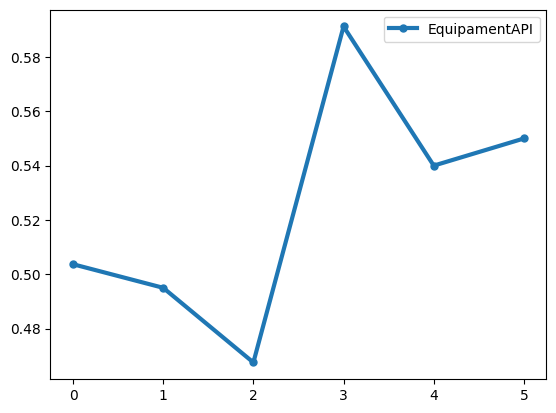

In [29]:

plt.plot(repo3['code_quality'], linewidth=3, marker='o', markersize=5, label="EquipamentAPI")
plt.legend()
...

Ellipsis

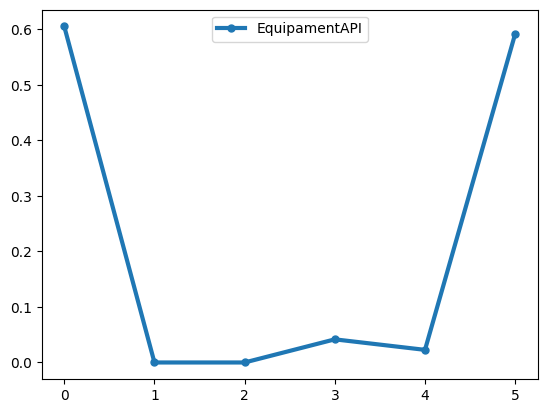

In [30]:

plt.plot(repo3['testing_status'], linewidth=3, marker='o', markersize=5, label="EquipamentAPI")
plt.legend()
...


In [31]:
repo3['Maintainability'] = repo3['code_quality'] * pc1
repo3['Reliability'] = repo3['testing_status'] * pc2
repo3['total'] = repo3['Maintainability'] + repo3['Reliability']
...

Ellipsis

In [32]:
#Alectrion EquipamentAPI
repo3

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.526316,0.0,1.000000,1.0,1.0,0.210526,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.11.0,3391,0.503684,0.605263,0.251842,0.302632,0.554474
1,0.500000,0.0,1.000000,0.0,0.0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.2.0,48,0.495000,0.000000,0.247500,0.000000,0.247500
2,0.416667,0.0,1.000000,0.0,0.0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.3.0,1113,0.467500,0.000000,0.233750,0.000000,0.233750
3,0.833333,0.0,0.958333,0.0,0.0,0.083333,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.4.0,5347,0.591250,0.041667,0.295625,0.020833,0.316458
4,0.727273,0.0,0.909091,0.0,0.0,0.045455,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.6.0,2905,0.540000,0.022727,0.270000,0.011364,0.281364
5,0.678161,0.0,0.988506,1.0,1.0,0.183908,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.8.0,8531,0.550000,0.591954,0.275000,0.295977,0.570977


Ellipsis

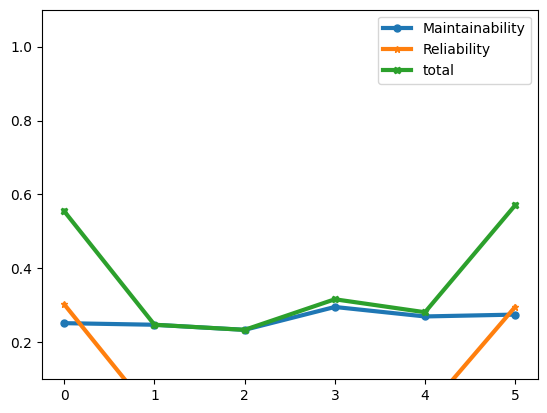

In [33]:
plt.plot(repo3['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(repo3['Reliability'], linewidth=3, marker='*', markersize=5, label="Reliability")
plt.plot(repo3['total'], linewidth=3, marker='X', markersize=5, label="total")
plt.legend()
plt.ylim(0.1,1.1)
...

### You must do the total plot and the statics analysis for the repository with more versions.

In [34]:
# Building descriptive statistics dataframe. You must replace YourRepoName for your repository name with more product versions.

metrics_df = pd.concat([repo3], ignore_index=True)

more_versions_repo = metrics_df[metrics_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-EquipamentApi']

def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

maintainability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [35]:
print(maintainability_stats)

       mean      mode    median       std       var      min       max
0  0.262286  0.233750  0.260921  0.022247  0.000495  0.23375  0.295625
1  0.262286  0.247500  0.260921  0.022247  0.000495  0.23375  0.295625
2  0.262286  0.251842  0.260921  0.022247  0.000495  0.23375  0.295625
3  0.262286  0.270000  0.260921  0.022247  0.000495  0.23375  0.295625
4  0.262286  0.275000  0.260921  0.022247  0.000495  0.23375  0.295625
5  0.262286  0.295625  0.260921  0.022247  0.000495  0.23375  0.295625


In [36]:
print(reliability_stats)

       mean  mode    median      std       var  min       max
0  0.105134   0.0  0.016098  0.15062  0.022686  0.0  0.302632


### Plotting the aggregated quality characteristic indicator

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb825e79ff0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb825e7a590>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb825e79d20>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb825e7ab30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb825e7ae00>,
 'means': []}

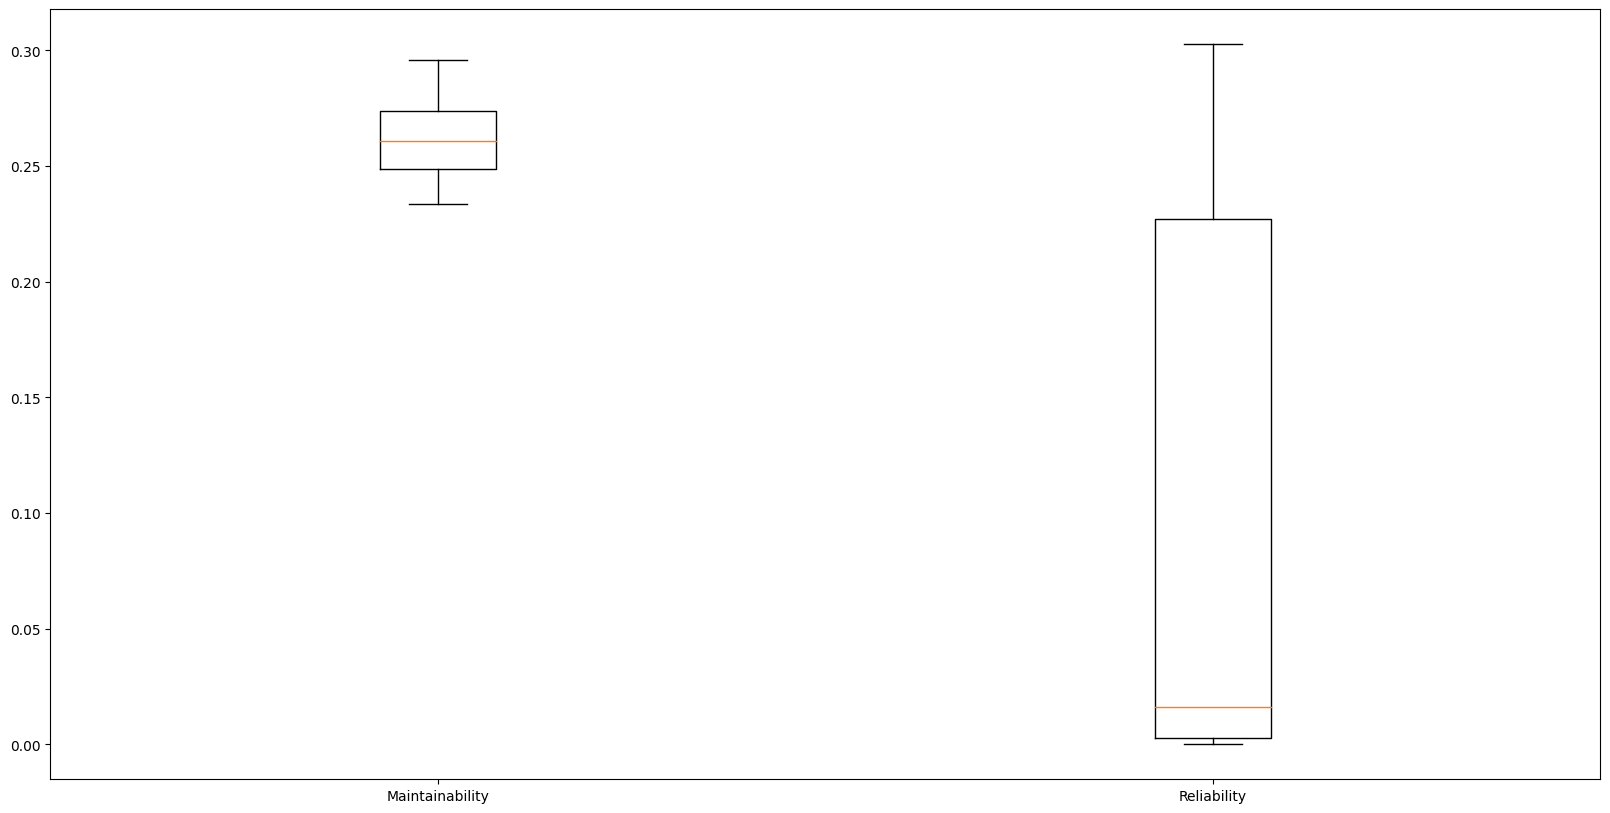

In [37]:
plt.figure(figsize=(20, 10))

# boxplot
plt.boxplot([more_versions_repo['Maintainability'], more_versions_repo['Reliability']],
labels=['Maintainability', 'Reliability'])

### Plotting the aggregated repository quality indicator

(0.1, 1.0)

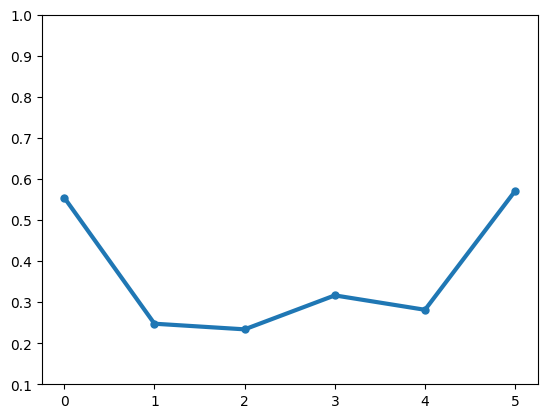

In [38]:
plt.plot(more_versions_repo['total'], linewidth=3, marker='o', markersize=5)

plt.ylim(.1,1)

In [39]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
#currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

#metrics_df.to_excel('data/fga-eps-mds-2022-1-Visualeasy-{}.xlsx'.format(currentDateTime), index = False)

#metrics_df.to_csv('data/fga-eps-mds-2022-1-Visualeasy-{}.csv'.format(currentDateTime), index = False)